匯入必要內容

In [557]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score
import kagglehub

# general setting. do not change TEST_SIZE
RANDOM_SEED = 42
TEST_SIZE = 0.3


匯入dataset 準備data

In [558]:
# load dataset（from kagglehub）
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data = pd.read_csv(f"{path}/creditcard.csv")
data['Class'] = data['Class'].astype(int)

# prepare data
data = data.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))



詐欺/非詐欺交易

In [559]:
fraud = data[data['Class'] == 1]
nonfraud = data[data['Class'] == 0]
print(f'Fraudulent:{len(fraud)}, non-fraudulent:{len(nonfraud)}')
print(f'the positive class (frauds) percentage: {len(fraud)}/{len(fraud) + len(nonfraud)} ({len(fraud)/(len(fraud) + len(nonfraud))*100:.3f}%)')    


Fraudulent:492, non-fraudulent:284315
the positive class (frauds) percentage: 492/284807 (0.173%)


監督式學習(random forest)

In [560]:
X = np.asarray(data.iloc[:, ~data.columns.isin(['Class'])])
Y = np.asarray(data.iloc[:, data.columns == 'Class'])

# split training set and data set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# build Random Forest model
rf_model = RandomForestClassifier(n_estimators=130, max_depth=20, min_samples_leaf=2, class_weight='balanced', random_state=RANDOM_SEED)
rf_model.fit(X_train, y_train)


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, n_estimators=130, random_state=42)

監督式學習result

In [561]:

# define evaluation function
def evaluation(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'\n{model_name} Evaluation:')
    print('===' * 15)
    print('         Accuracy:', accuracy)
    print('  Precision Score:', precision)
    print('     Recall Score:', recall)
    print('         F1 Score:', f1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

# predict and print result
y_pred = rf_model.predict(X_test)
evaluation(y_test, y_pred)
# print(classification_report(y_test, y_pred))





Model Evaluation:
         Accuracy: 0.9996488887328394
  Precision Score: 0.9416666666666667
     Recall Score: 0.8308823529411765
         F1 Score: 0.8828125

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.94      0.83      0.88       136

    accuracy                           1.00     85443
   macro avg       0.97      0.92      0.94     85443
weighted avg       1.00      1.00      1.00     85443



非監督式學習(Kmeans)

In [ ]:

from sklearn.decomposition import PCA
# Extract features and labels
X = np.asarray(data.drop(columns=['Class']))
y = np.asarray(data['Class'])

# Split the dataset into training and testing sets (with stratification)
x_train, x_test, y_train, y_test = train_test_split(
   X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

#降維處理
pca = PCA(n_components=26,random_state=RANDOM_SEED)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


# Select a small sample of normal (non-fraud) data for unsupervised training
n_x_train = x_train[y_train == 0]
n_x_train = n_x_train[:1000]

scores = []
k_range = range(2, 15)
for k in k_range:
   kmeans = KMeans(n_clusters=k, init='k-means++', n_init=1000, max_iter=500, random_state=RANDOM_SEED)
   kmeans.fit(n_x_train)
   score = silhouette_score(n_x_train, kmeans.labels_)
   scores.append(score)

optimal_k = np.argmax(scores) + 2
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init=1000, max_iter=500, random_state=RANDOM_SEED)
kmeans.fit(n_x_train)
y_pred_test = kmeans.predict(x_test)

def align_labels(y_true, y_pred, n_clusters):
   labels = np.zeros_like(y_pred)
   for i in range(n_clusters):
       mask = (y_pred == i)
       if np.sum(mask) > 0:
           labels[mask] = np.bincount(y_true[mask]).argmax()
       else:
           labels[mask] = 0  # Default to normal class
   return labels

y_pred_aligned = align_labels(y_test, y_pred_test, optimal_k)



非監督式學習result

In [556]:
def evaluation(y_true, y_pred, model_name="Model"):
   accuracy = accuracy_score(y_true, y_pred)
   precision = precision_score(y_true, y_pred, zero_division=0)
   recall = recall_score(y_true, y_pred)
   f1 = f1_score(y_true, y_pred)

   print(f'\n{model_name} Evaluation:')
   print('===' * 15)
   print('         Accuracy:', accuracy)
   print('  Precision Score:', precision)
   print('     Recall Score:', recall)
   print('         F1 Score:', f1)
   print("\nClassification Report:")
   print(classification_report(y_true, y_pred))

evaluation(y_test, y_pred_aligned, model_name="KMeans (Unsupervised)")


KMeans (Unsupervised) Evaluation:
         Accuracy: 0.9987594068560327
  Precision Score: 0.7916666666666666
     Recall Score: 0.38513513513513514
         F1 Score: 0.5181818181818182

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.79      0.39      0.52       148

    accuracy                           1.00     85443
   macro avg       0.90      0.69      0.76     85443
weighted avg       1.00      1.00      1.00     85443



混淆矩陣(非監督式)

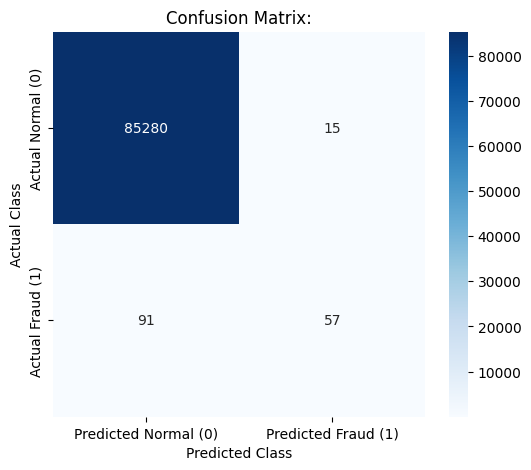

In [553]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_aligned) # 使用 y_pred_aligned
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal (0)', 'Predicted Fraud (1)'],
            yticklabels=['Actual Normal (0)', 'Actual Fraud (1)'])
plt.title(f'Confusion Matrix:')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()